#이미지 분류기 학습하기 
- torchvision을 사용하여 데이터 로드 및 전처리(정규화)
- CNN 모델 정의 
- 손실 함수 정의 
- 학습용 데이터을 사용해 학습 
- 시험용 데이터를 사용해 학습 

# 데이터 로드 및 전처리 
- torchvision을 사용하여 CIFAR10 로드 

In [1]:
import torchvision 
import torch 
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

batch_size = 4 

trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2
                                          )
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False,num_workers=2)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


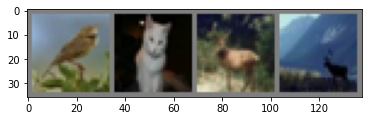

bird  cat   deer  deer 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# 모델

## 모델 정의 

In [34]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = 'cuda:0'
net = Net().to(device)

## 손실함수 및 optimizer 정의 

In [30]:
import torch.optim as optim 

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001, momentum=0.9)

## 신경망 학습하기 

In [35]:
epochs = 2 
for epoch in range(epochs):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, (inputs,labels) in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs,labels = inputs.to(device),labels.to(device)
        

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.305
[1,  4000] loss: 2.306
[1,  6000] loss: 2.304


KeyboardInterrupt: ignored

# 추론 

## 테스트 데이터 확인 

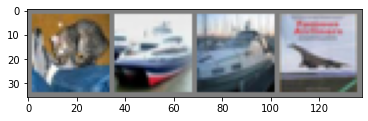

GroundTruth:  cat   ship  ship  plane


In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## 단일 데이터 추론 

In [11]:
images = images.to(device)
outputs = net(images)
_,predicted = torch.max(outputs,1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   car   ship 


## 테스트 데이터 전체 추론 

In [23]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images,labels = images.to(device), labels.to(device)
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


In [24]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images,labels = images.to(device),labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 49.9 %
Accuracy for class: car   is 83.1 %
Accuracy for class: bird  is 31.7 %
Accuracy for class: cat   is 11.9 %
Accuracy for class: deer  is 40.9 %
Accuracy for class: dog   is 70.5 %
Accuracy for class: frog  is 75.3 %
Accuracy for class: horse is 65.9 %
Accuracy for class: ship  is 68.8 %
Accuracy for class: truck is 52.4 %
